In [32]:
# download annual historical data for the stock
import pandas as pd
df = pd.read_csv("TSLA.csv")
df = df.sort_values(by="Date")
df = df.dropna()
# calculate returns
df = df.assign(close_day_before=df.Close.shift(1))
df['returns'] = ((df.Close - df.close_day_before)/df.close_day_before)

# get options data from yahoo finance // in this case, exercise data is july 24th
r = pd.read_html('https://finance.yahoo.com/quote/TSLA/options?date=1609372800&p=TSLA')[0]

In [33]:
len(r)

131

In [34]:
r.head()

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility
0,TSLA201231C00020000,2020-12-24 9:36AM EST,20.0,623.05,639.90,643.65,-2.4,-0.38%,1,12,850.00%
1,TSLA201231C00040000,2020-12-21 1:50PM EST,40.0,623.10,620.00,623.70,0.0,-,10,12,829.69%
2,TSLA201231C00060000,2020-12-21 10:42AM EST,60.0,602.90,599.90,603.70,0.0,-,5,13,646.88%
3,TSLA201231C00080000,2020-12-23 10:36AM EST,80.0,569.20,580.00,583.70,569.2,-,-,5,618.75%
4,TSLA201231C00100000,2020-12-21 1:16PM EST,100.0,568.05,559.95,563.65,0.0,-,5,5,509.38%


In [35]:
# S is the spot price 
# K is the strike price 
# T is the fraction of days to strike date divided by 252 (stock market days)
# r is the risk free rate
# sigma is the annual volatility of the returns of the stock 

def black_scholes(S, K, T, r, sigma):
    d1 = np.log(S/(K/(1 + r)**T)/(sigma*sqrt(T))) + (sigma*sqrt(T))/2
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - (K/(1 + r)**T) * norm.cdf(d2)

In [36]:
from math import sqrt
import numpy as np
from scipy.stats import norm

# Calculate the volatility as the annualized standard deviation of the stock returns
sigma = np.sqrt(252) * df['returns'].std()

list_estimates = []

# currently 35 different strike prices for call contracts 
for x in range(0,131):
    value_s = black_scholes(S = 661.77, 
                            K = r['Strike'][x], 
                            T = (40/252), 
                            r = 0.0094, 
                            sigma = sigma)
    list_estimates.append(value_s)
    

# merge the two lists to compare results
df_list = pd.DataFrame(data=list_estimates, index=r.index)
df_list['estimate_1'] = df_list[0]
del df_list[0]
df_estimate = r.merge(df_list, right_index = True, left_index = True)

In [41]:
df_estimate.head()

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,estimate_1,estimate_error
0,TSLA201231C00020000,2020-12-24 9:36AM EST,20.0,623.05,639.90,643.65,-2.4,-0.38%,1,12,850.00%,641.798988,0.288410
1,TSLA201231C00040000,2020-12-21 1:50PM EST,40.0,623.10,620.00,623.70,0.0,-,10,12,829.69%,621.814780,0.303180
2,TSLA201231C00060000,2020-12-21 10:42AM EST,60.0,602.90,599.90,603.70,0.0,-,5,13,646.88%,601.791879,0.317073
3,TSLA201231C00080000,2020-12-23 10:36AM EST,80.0,569.20,580.00,583.70,569.2,-,-,5,618.75%,581.714009,0.341403
4,TSLA201231C00100000,2020-12-21 1:16PM EST,100.0,568.05,559.95,563.65,0.0,-,5,5,509.38%,561.580916,0.368439


In [38]:
df_estimate['estimate_error'] = ((df_estimate['Ask'] - df_estimate['estimate_1'])/df_estimate['estimate_1'])*100

df_estimate['estimate_error'].describe()

count    131.000000
mean     -40.199137
std       42.629352
min     -117.505926
25%     -100.004640
50%      -17.269371
75%       -2.316255
max        0.655159
Name: estimate_error, dtype: float64

/home/avocado/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


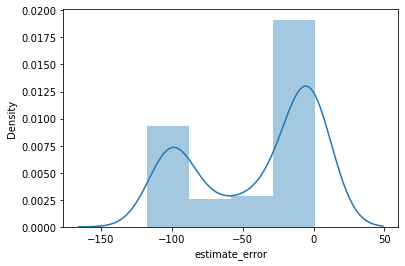

In [39]:
import seaborn as sns, numpy as np
ax = sns.distplot(df_estimate['estimate_error'])

/home/avocado/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


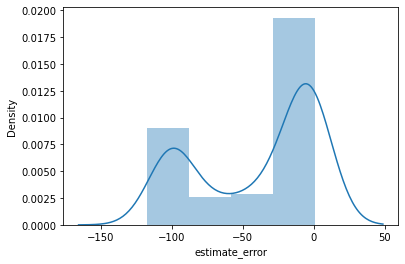

In [42]:
df1 = df_estimate[(df_estimate.Volume != '-')]
ax = sns.distplot(df1['estimate_error'])

In [15]:
df1[df1['estimate_error'] > 1]

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,estimate_1,estimate_error
